In [207]:
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/libraries_analysis.R')
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_functions/cdr3-QTL_functions.R')
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_functions/hla_functions.R')


In [5]:
load('/work_beegfs/sukmb667/projects/cdr3-qtl/CDR3QTL/cdr3-hla-pairs/irt_freq_unique.RData')

### Conditional with the allele dosage approach

In [11]:
manova_results <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/manova_results/irt_freq_unique/Main_manova_irt_freq_with_groups.csv')

condition_site <- define_cond_hit(manova_results)
hla_matrices <- '/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/hla_matrices/with_pcs/'
condition_site_df <- fread(paste0(hla_matrices, grep(paste0(condition_site, '.tsv'), list.files(hla_matrices), value = TRUE))) %>%
        dplyr::select(-G_S) %>% dplyr::select(!contains('PC'))

first <- TRUE
colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
if(first){
    covariates_df <- condition_site_df
    first <- FALSE
    } else {
    covariates_df <- inner_join(covariates_df, condition_site_df)
    }

sites <- colnames(covariates_df)[-1] 

In [13]:
hit_pattern <- paste0(condition_site,'_')
all_pairs <- sapply(data_table_list, function(x) x$pair[1])
pairs_to_test <- grep(hit_pattern, all_pairs, value = TRUE, invert = TRUE)
filtered_list <- data_table_list[sapply(data_table_list, function(dt) {
  !any(grepl(hit_pattern, dt[1, pair]))
})]

In [14]:
filtered_list_with_cov <- sapply(filtered_list, function(dt) merge(dt, covariates_df, by = 'patient_id', all.x = TRUE))

In [82]:
tested <- unique(df$pair)
filtered_list_with_cov_continue <- filtered_list_with_cov[sapply(filtered_list_with_cov, function(dt) {
  !any(dt[1, ] %in% tested) 
})]

In [ ]:
manova_results

### Conditional with Categorical HLA alleles

In [35]:
categorical_cov_dt <- covariates_df[, .(
  DRB1_13 = apply(.SD, 1, function(x) {
    gsub(condition_site, "", paste0(names(.SD)[x > 0], collapse = ""))
  })
), .SDcols = patterns("^DRB1_13"), by = patient_id]

In [36]:
data_with_categorical_cov_dt <- merge(data_table_list[[1]], categorical_cov_dt, by = 'patient_id', all.x = TRUE)

### CDR3-QTL only by phenotypes

In [107]:
source("/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_scripts/CDR3-QTL-only-by-phenotype.r")

In [156]:
mlmm_groups_all <- mlmm_groups_all %>% mutate(significant = ifelse(Pvalue < 0.05/70, Pvalue, 0.05))
pl <- ggplot(data = mlmm_groups_all, aes(x = IMGT, y = Length_cdr3)) +
    geom_tile(aes(fill = -log10(significant))) +
    geom_text(aes(label = round(variance_explained, 3)), color = "black", size = 3) +
    scale_fill_viridis_c(option = 'magma') +
    theme_cowplot() + 
    labs(x = 'CDR3 non-germline positions', y = 'Length CDR3', 
        fill = expression(-log10(Pvalue)),title = 'CDR3 variance explained by phenotypes') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.box = "horizontal", legend.position = "bottom") 

ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/CDR3_variance_explained_by_phenotypes.png', pl, width = 10, height = 10)

In [157]:
mlmm_groups_all %>% arrange(Pvalue) %>% head()

Res.Df,Df,Gen.var.,Pillai,approx F,num Df,den Df,Pvalue,P_val,variance_explained,pair,Length_cdr3,IMGT,significant
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1919,-2,0.6418331,0.1252209,6.348613,40,3802,1.215899e-31,0.000000e+00,0.011672030,L14_P112,L14,P112,1.215899e-31
1919,-2,0.6332916,0.1237373,6.268432,40,3802,4.371151e-31,0.000000e+00,0.013239051,L15_P112,L15,P112,4.371151e-31
1919,-2,0.6152519,0.1215963,6.152951,40,3802,2.751294e-30,0.000000e+00,0.013067959,L16_P112.1,L16,P112.1,2.751294e-30
1919,-2,0.7050610,0.1192562,6.027029,40,3802,2.035596e-29,0.000000e+00,0.010206825,L16_P112,L16,P112,2.035596e-29
1919,-2,0.6039114,0.1180254,5.960928,40,3802,5.808489e-29,2.496769e-11,0.006475382,L15_P113,L15,P113,5.808489e-29
1919,-2,0.5066551,0.1104014,5.553378,40,3802,3.603705e-26,2.120526e-13,0.008668347,L15_P110,L15,P110,3.603705e-26


### Conditional with PERMANOVA and Categorical Conditional Covariate

In [ ]:
cdr3_hla_matrix <- data_with_categorical_cov_dt
name_pair <- unique(cdr3_hla_matrix$pair)
n_pcs <- 3

vars <- define_variables(cdr3_hla_matrix)
Y <- paste0('cbind(', paste(colnames(vars[[2]]), collapse = ','),") ~")
hlas <- paste(vars[[1]], collapse = '+')
pcs <- paste0('PC', seq(1,n_pcs), collapse = '+')
X_full <- paste(hlas, 'group + DRB1_13', sep = '+')
X_null <- paste('group + DRB1_13')

formula_full <- as.formula(str_c('Y_matrix ~', X_full))
formula_null <- as.formula(str_c('Y_matrix ~', X_null))

permod1 <- adonis2(formula_full, data = cdr3_hla_matrix, parallel = 20, method = "bray", permutations = 9999)
permod0 <- adonis2(formula_full, data = cdr3_hla_matrix, parallel = 20, method = "bray", permutations = 9999)

pair_name <- cdr3_hla_matrix$pair[1]
permanova_dt <- rbind(as.data.table(permod1[1,]), as.data.table(permod0[1,]))
permanova_dt$model <- c('full', 'null')
permanova_dt$pair <- pair_name
permanova_dt$var_exp <- permod1$R2[1] - permod0$R2[1]
aic_permod1 <- AICc_permanova2(permod1)
aic_permod0 <- AICc_permanova2(permod0)
permanova_dt$aic <- aic_permod0$AICc - aic_permod1$AICc



In [4]:
hla_matrices <- '../hla_matrices/with_pcs/'
pcs <- 3
dir_downsampling <- '../CDR3_downsampling_experiment/'
dir_content <- paste0(dir_downsampling, list.files(dir_downsampling))

for (path_in in dir_content){
    dir_analysis <- paste0(path_in, '/conditional_analysis/')
    if (!file.exists(dir_analysis)) {
        dir.create(dir_analysis, recursive = TRUE)
        }
    pairs_to_test <- paste0(path_in,'/cdr3_hla_pairs/')
    sample_size <- unlist(strsplit(path_in, '/'))[3]
    manova_cond_all <- fread(paste0(path_in,'/',sample_size,'_manova.tsv'))
    bonf <- 0.01 / nrow(na.omit(manova_cond_all))
            
    source('Conditional_analysis_updated.R')
                 }

ERROR: Error: File '../hla_matrices/with_pcs/' is a directory. Not yet implemented.


In [42]:
phenotypes %>% group_by(group) %>% count() 

group,n
<chr>,<int>
CD,1026
HLH,772
UC,402


NULL

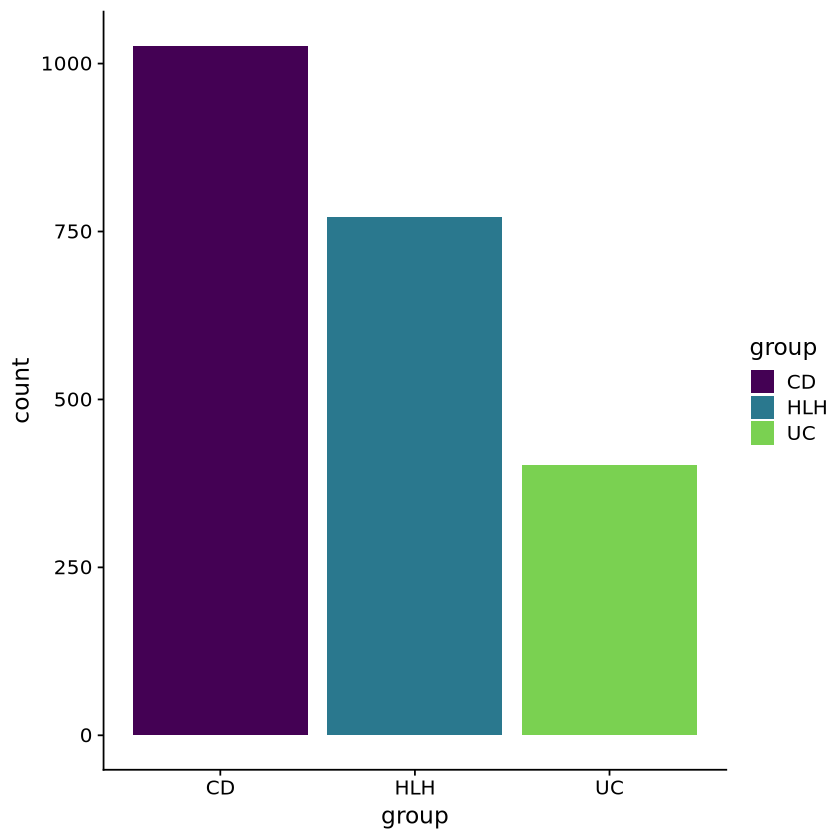

In [37]:
phenotypes <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/phenotypes.tsv')
ggplot(data = phenotypes, aes(x = group, fill = group)) +
    geom_bar(stat = 'count') +
    theme_cowplot() +
    scale_fill_viridis_d(end = 0.8)
    labs(x = 'Phenotype', y = 'Value', fill = 'Phenotype') +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Conditional haplotype analysis with the approach from HLA tutorial


In [43]:
phenotype <- 'I'
hla_genes <- c('DQB1', 'DQA1', 'B', 'DPB1', 'DPA1', 'A', 'C')
hla_gene <- 'DQA1'
cond_round <- 2
using_groups <- FALSE
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_scripts/Conditional_haplotype_on_combined_IKMB_data.r')

Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `Pvalue == min(Pvalue)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `filter()`.
ℹ In argument: `variance_explained == max(variance_explained)`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf”
Warning message in min(na.omit(manova_cond_all$Pvalue)):
“no non-missing arguments to min; returning Inf”


### Conditional on both

In [300]:
phenotype <- 'both'
hla_genes <- c('DQB1', 'DQA1', 'B', 'DPB1', 'DPA1', 'A', 'C')
hla_gene <- 'B'
cond_round <- 0
using_groups <- TRUE
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_scripts/Conditional_haplotype_on_combined_IKMB_data.r')

ERROR: Error: File '/work_beegfs/sukmb667/projects/cdr3-qtl/data/healthy_and_ibd/phenotypes.tsv' does not exist or is non-readable. getwd()=='/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/Notebooks'


## Conditional haplotype with known HLA-DRB1 and HLA-DQ haplotypes

In [ ]:
phenotype <- 'both'
hla_gene <- 'DQA1'
cond_round <- 0
using_groups <- FALSE
source('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/scripts/R_scripts/Conditional_haplotype_with_DRB1_DQA1.r')

In [ ]:
manova_cond_all

: 

In [308]:
merged <- merge(
              dt_drb1, dt_dqa1,
              by = "patient_id", allow.cartesian = TRUE, suffixes = c("_drb1", "_dqa1")
            )
merged <- merged[, .(
  Site_hla_AA_drb1 = paste(unique(Site_hla_AA_drb1), collapse = "_"),
    homo_hetero_drb1 = unique(homo_hetero_drb1),
    allele_dqa1 = unique(allele_dqa1),
    allele_drb1 = unique(allele_drb1),
    homo_hetero_dqa1 = unique(homo_hetero_dqa1),
    Site_hla_AA_dqa1 = unique(Site_hla_AA_dqa1)
    # Assuming col3 is always the same within group
), by = .(patient_id, allele_drb1)]
# Create haplotype label
merged[, haplo := paste0(Site_hla_AA_drb1, "_", Site_hla_AA_dqa1)]

dqa1_haplotypes <- hla_site_correlations[HLA1 != HLA2][Var1 %like% paste0(sites[[2]],'_')][Var2 %like% paste0(sites[[1]],'_')][value > -0.1]
dqa1_haplotypes_alleles <- hla_alleles_correlations[value > 0.2][Var1!=Var2][Var1 %like% 'DRB1'][Var2 %like% 'DQA1']

valid <- merged[dqa1_haplotypes_alleles, 
  on = .(allele_dqa1 = Var2, allele_drb1 = Var1), 
  nomatch = 0
]
valid_cleaned <- unique(valid[, .(patient_id, homo_hetero_drb1, homo_hetero_dqa1, haplo)])[, homo_hetero := min(homo_hetero_drb1, homo_hetero_dqa1), by = patient_id][,
    homo_hetero := if (.N == 1) 2 else homo_hetero, by = patient_id] %>% arrange(patient_id)
conditional_matrix <- dcast(valid_cleaned, patient_id ~ haplo, value.var = 'homo_hetero', fill = 0, fun.aggregate = sum)

In [294]:
sum_allele_dos <- rowSums(conditional_matrix[, -1])
conditional_matrix$sum_allele_dosages <- sum_allele_dos
conditional_matrix %>% filter(sum_allele_dosages != 2)

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


patient_id,DRB1_13_F_DRB1_67_F_DRB1_86_G_DQA1_107_T,DRB1_13_F_DRB1_67_L_DRB1_86_G_DQA1_107_T,DRB1_13_F_DRB1_67_L_DRB1_86_V_DQA1_107_T,DRB1_13_G_DRB1_67_F_DRB1_86_G_DQA1_107_T,DRB1_13_G_DRB1_67_I_DRB1_86_G_DQA1_107_T,DRB1_13_G_DRB1_67_I_DRB1_86_V_DQA1_107_I,DRB1_13_H_DRB1_67_I_DRB1_86_V_DQA1_107_T,DRB1_13_H_DRB1_67_L_DRB1_86_G_DQA1_107_T,DRB1_13_H_DRB1_67_L_DRB1_86_V_DQA1_107_T,⋯,DRB1_13_R_DRB1_67_I_DRB1_86_V_DQA1_107_T,DRB1_13_S_DRB1_67_F_DRB1_86_G_DQA1_107_I,DRB1_13_S_DRB1_67_F_DRB1_86_V_DQA1_107_I,DRB1_13_S_DRB1_67_I_DRB1_86_G_DQA1_107_I,DRB1_13_S_DRB1_67_I_DRB1_86_G_DQA1_107_T,DRB1_13_S_DRB1_67_I_DRB1_86_V_DQA1_107_T,DRB1_13_S_DRB1_67_L_DRB1_86_V_DQA1_107_I,DRB1_13_S_DRB1_67_L_DRB1_86_V_DQA1_107_T,DRB1_13_Y_DRB1_67_I_DRB1_86_G_DQA1_107_T,sum_allele_dosages
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


### Visualisation of correlations between HLA sites

In [67]:
hla_variable_sites_all <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/hla/hla_site_variations_healthy_and_ibd_all_variable_sites_updated.tsv')

In [68]:
hla_variable_sites_all[, hla_site_aa := paste(HLA, Site_hla, AA, sep = "_")]
hla_site_aa_wide <- dcast(hla_variable_sites_all, patient_id ~ hla_site_aa, value.var = 'homo_hetero', fill = 0)
hla_site_aa_wide <- hla_site_aa_wide %>% dplyr::select(-patient_id) %>% as.data.frame()
hla_sites_correlations_matrix <- cor(hla_site_aa_wide, method = 'spearman')
hla_site_correlations <- melt(hla_sites_correlations_matrix)
hla_site_correlations <- hla_site_correlations %>% separate(Var1, into = c('HLA1', 'Site_hla1', 'AA1'), sep = '_', remove = FALSE) %>% 
    separate(Var2, into = c('HLA2', 'Site_hla2', 'AA2'), sep = '_', remove = FALSE)
hla_site_correlations <- as.data.table(hla_site_correlations)

In [93]:
fwrite(hla_site_correlations, '/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/hla/hla_site_correlations.tsv', sep = '\t')

In [69]:
hla_high_cor <- hla_site_correlations %>% filter(abs(value) > 0.6, HLA1 != HLA2)
hla_high_cor$list_var <- Map(function(x, y) sort(c(x, y)), 
    hla_high_cor$Var1, 
    hla_high_cor$Var2)
hla_high_cor$list_var <- sapply(hla_high_cor$list_var, paste, collapse = ':')
hla_high_cor <- unique(hla_high_cor, by = 'list_var')

In [ ]:
hlh_hla <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/hla/healthy_hla_variations_long.tsv')
hlh_hla <- rename(hlh_hla, HLA = gene, Site_hla = site)[, .(HLA, allele, patient_id, homo_hetero, Site_hla, AA)]
hlh_hla[,patient_id := paste0('H', patient_id)]
ibd_hla <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/hla/ibd_hla_variations_long.tsv')
ibd_hla <- rename(ibd_hla, HLA = gene, Site_hla = site)[, .(HLA, allele, patient_id, homo_hetero, Site_hla, AA)]
ibd_hla[,patient_id := paste0('I', patient_id)]
all_hla <- rbind(hlh_hla, ibd_hla)
all_hla[, Site_hla := paste0(HLA, '_', Site_hla)]
fwrite(all_hla, '/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/hla/all_hla_variations_long.tsv', sep = '\t')

In [2]:
all_hla <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/hla/all_hla_variations_long.tsv')

In [4]:
head(all_hla)

HLA,allele,patient_id,homo_hetero,Site_hla,AA
<chr>,<chr>,<chr>,<int>,<chr>,<chr>
A,A*01:01,H0,1,A_9,F
A,A*01:01,H0,1,A_12,V
A,A*01:01,H0,1,A_17,R
A,A*01:01,H0,1,A_43,Q
A,A*01:01,H0,1,A_44,K
A,A*01:01,H0,1,A_56,G


## Correlations between alleles

In [19]:
patients_allele <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/data/hla/hla_genotypes_matrix.csv')

In [263]:
hla_alleles_correlations_matrix <- cor(patients_allele[,-1], method = 'spearman')
hla_alleles_correlations <- melt(hla_alleles_correlations_matrix)
hla_alleles_correlations <- as.data.table(hla_alleles_correlations)
hla_high_cor_alleles <- hla_alleles_correlations %>% filter(abs(value) > 0.6, Var1 != Var2)
hla_high_cor_alleles$list_var <- Map(function(x, y) sort(c(x, y)), 
    hla_high_cor_alleles$Var1, 
    hla_high_cor_alleles$Var2)
hla_high_cor_alleles$list_var <- sapply(hla_high_cor_alleles$list_var, paste, collapse = ':')
hla_high_cor_alleles <- unique(hla_high_cor_alleles, by = 'list_var')
hla_high_cor_alleles %>% head()

Warning message in stats::cor(x, y, use, method):
“the standard deviation is zero”


Var1,Var2,value,list_var
<fct>,<fct>,<dbl>,<chr>
C*16:01,A*29:02,0.6752443,A*29:02:C*16:01
C*07:02,B*07:02,0.9264411,B*07:02:C*07:02
C*15:05,B*07:05,0.6313001,B*07:05:C*15:05
C*07:01,B*08:01,0.8145965,B*08:01:C*07:01
DRB1*03:01,B*08:01,0.7088284,B*08:01:DRB1*03:01
C*08:02,B*14:02,0.9199648,B*14:02:C*08:02


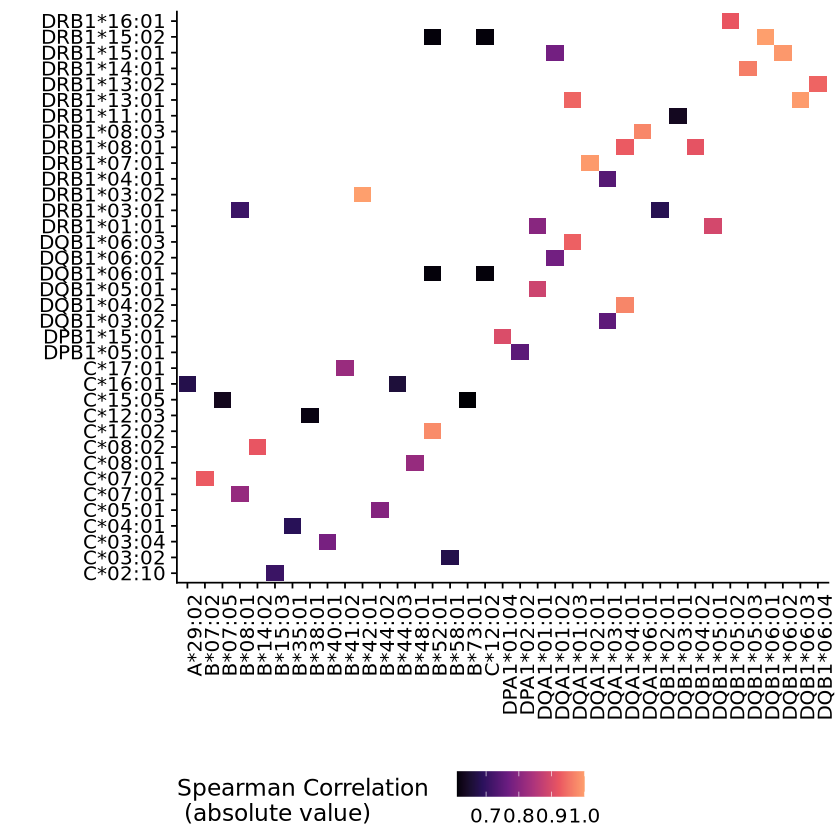

In [33]:
library(cowplot)
# %>% filter(Var1 %like% c('DQB1'))
pl <- ggplot(hla_high_cor_alleles %>% filter(value > 0) , aes(x = Var1, y = Var2, fill = value)) + 
    geom_tile() +
    scale_fill_viridis_c(option = 'magma', end = 0.8) +
    theme_cowplot() + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1), 
        legend.box = "horizontal", 
        legend.position = "bottom") +
    labs(x = ' ', y = ' ', fill = 'Spearman Correlation \n (absolute value)') +
    coord_flip()
pl
ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/hla_all_alleles_correlations.png', pl, width = 30, height = 30)
ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/hla_all_alleles_correlations.pdf', pl, width = 30, height = 30)

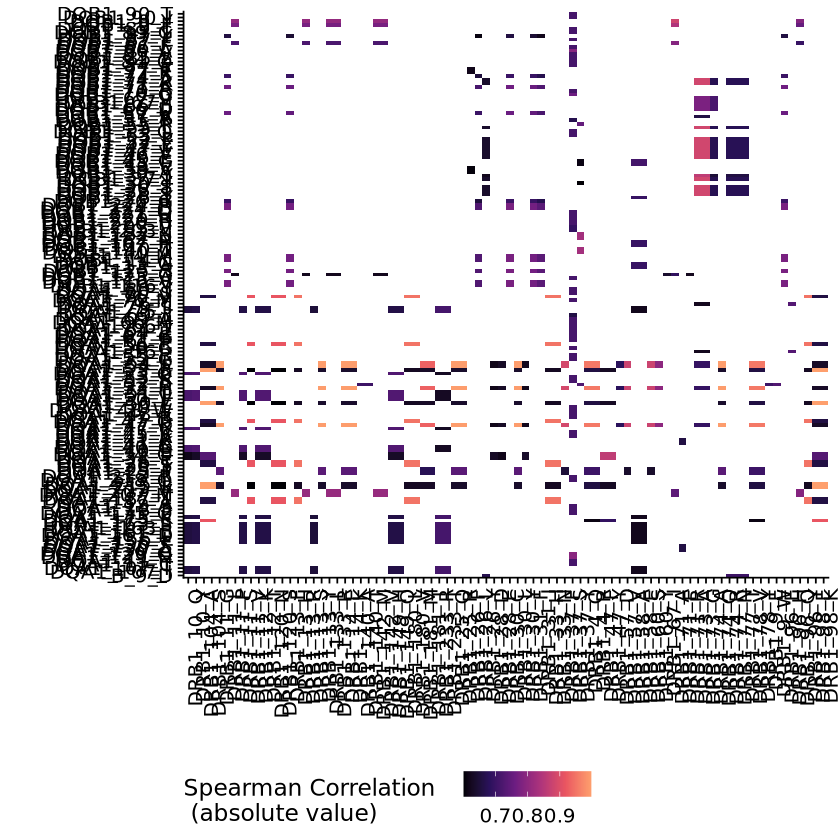

In [ ]:
pl <- ggplot(hla_high_cor %>% filter(HLA1 %in% c('DRB1')), aes(x = Var1, y = Var2, fill = abs(value))) + 
    geom_tile() +
    scale_fill_viridis_c(option = 'magma', end = 0.8) +
    theme_cowplot() + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1), 
        legend.box = "horizontal", 
        legend.position = "bottom") +
    labs(x = ' ', y = ' ', fill = 'Spearman Correlation \n (absolute value)')
pl
ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/hla_drb1_correlations.png', pl, width = 20, height = 30)
ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/hla_drb1_correlations.pdf', pl, width = 20, height = 30)

In [112]:
hla_high_cor_site_level <- hla_high_cor
hla_high_cor_site_level[, Var1 := Map(function(x, y) paste0(x,'_', y),
    hla_high_cor_site_level$HLA1, 
    hla_high_cor_site_level$Site_hla1)][, Var2 := Map(function(x, y) paste0(x,'_', y),
    hla_high_cor_site_level$HLA2, 
    hla_high_cor_site_level$Site_hla2)]

In [125]:
hla_high_cor_site_level_for_plot <- hla_high_cor_site_level %>% 
    group_by(Var1, Var2) %>% 
    filter(abs(value) == max(abs(value))) %>% 
    slice(1) %>%
    dplyr::select(HLA1, Var1, HLA2, Var2, value) %>%
    unique() %>% 
    ungroup()  %>%
    as.data.table() 

In [63]:
all_hla

ERROR: Error in eval(expr, envir, enclos): object 'all_hla' not found


In [64]:
hla_high_cor_site_level_for_plot%>% head(20)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'hla_high_cor_site_level_for_plot' not found


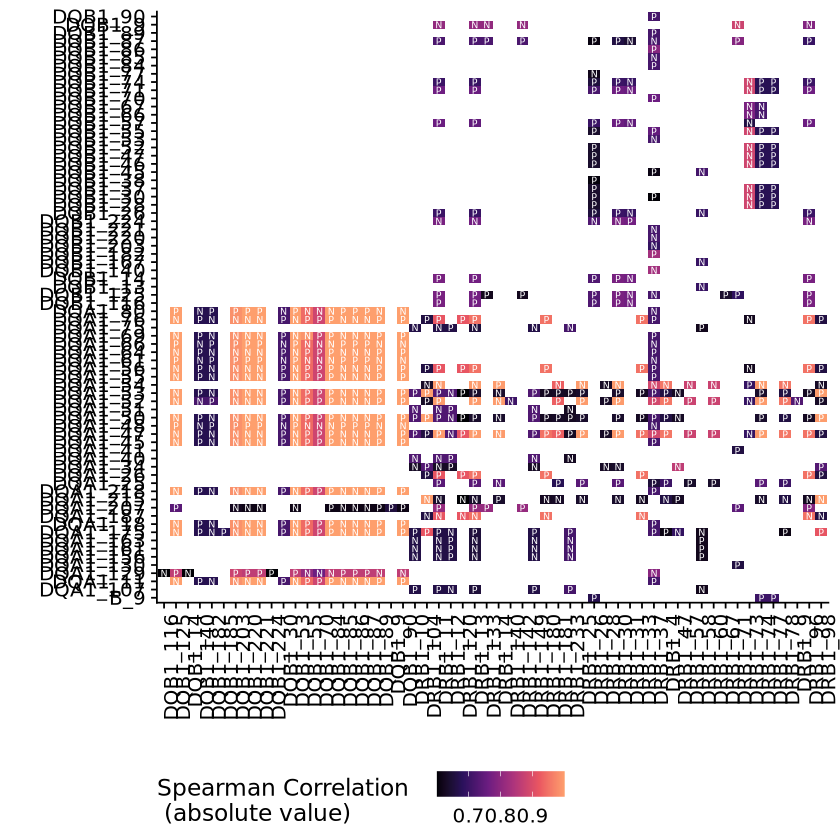

In [150]:
pl <- ggplot(hla_high_cor_site_level_for_plot %>% filter(HLA1 %in% c('DRB1', 'DQB1', 'DQA1')), 
    aes(x = unlist(Var1), y = unlist(Var2))) + 
    geom_tile(aes(fill = abs(value))) +
    scale_fill_viridis_c(option = 'magma', end = 0.8) +
    geom_text(aes(label = ifelse(value > 0, 'P', 'N')), size = 2, color = 'white') + 
    theme_cowplot() + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1), 
        legend.box = "vertical", 
        legend.position = "bottom") +
    labs(x = ' ', 
        y = ' ', 
        fill = 'Spearman Correlation \n (absolute value)',
        color = 'Direction of correlation') 
pl
ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/hla_II_correlations_max_sites.png', pl, 
    width = 20, height = 20)
ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/hla_II_correlations_max_sites.pdf', pl, 
    width = 20, height = 20)

## Visualising Conditional sites

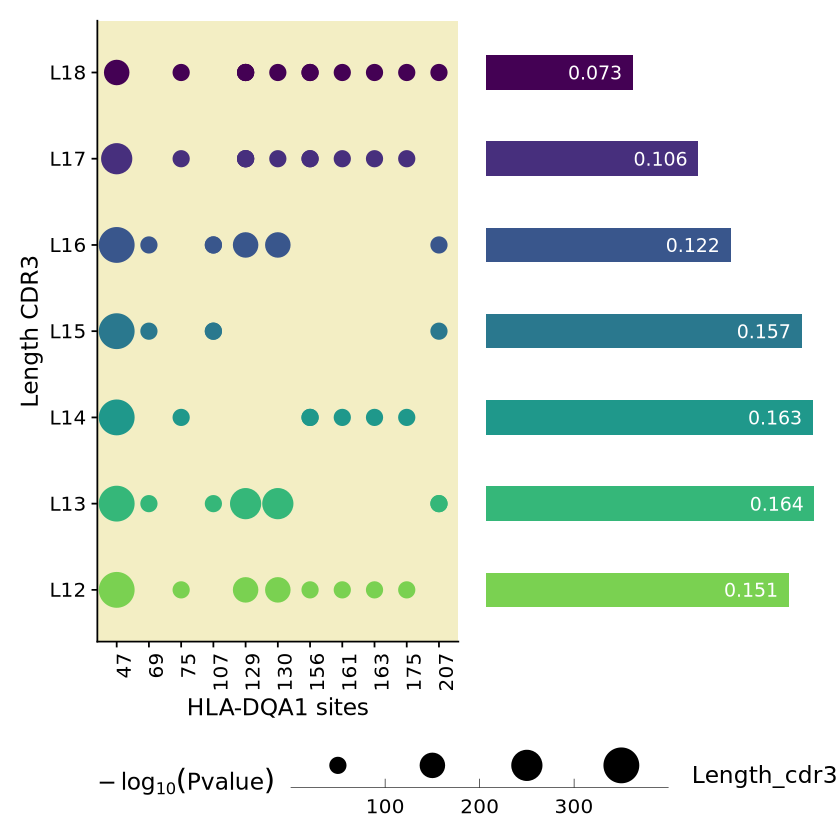

In [381]:
smallest_number <- .Machine$double.xmin

hla_gene <- 'DQA1'
n_rounds <- 3

df_all <- na.omit(fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/manova_results/main_manova_as_in_Ishigaki.tsv')[, 
        Length_cdr3 := paste0('L', Length_cdr3)][HLA == hla_gene]) %>% 
        rename('Pvalue' = 'Pr(>F)', 'IMGT' = 'Position_cdr3', 'condition' = 'Site_hla') %>% 
        group_by(Length_cdr3) %>% unique() %>% 
        filter(Pvalue == min(Pvalue)) %>% 
        filter(variance_explained == max(variance_explained))%>%
        ungroup() %>%
        dplyr::select(Length_cdr3, Pvalue, IMGT, variance_explained, condition) 
df_all$cond_round <- 0

n_tests <- 0
for (i in seq(1,n_rounds)){
    file_path <- paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis/with_groups/both/',hla_gene,'_conditional_round_',i,'.tsv')
    n_df <- nrow(fread(file_path))
    n_tests <- n_tests + n_df
}

for (i in seq(1,n_rounds)){
    file_path <- paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis/with_groups/both/',hla_gene,'_conditional_round_',i,'.tsv')
    df <- na.omit(fread(file_path)) %>% 
        filter(Pvalue <= 0.05/n_tests) %>%
        group_by(Length_cdr3) %>% unique() %>%
        filter(Pvalue == min(Pvalue)) %>%
        ungroup() %>%
        dplyr::select(Length_cdr3, Pvalue, IMGT, Omnibus, condition) %>%
        rename('variance_explained' = 'Omnibus') %>%
        mutate(cond_round = i)
    df_all <- rbind(df_all, df)
}

df_all_long <- df_all %>% 
    separate_rows(condition, sep = '_') %>% 
    group_by(condition) %>% 
    mutate(n_obs = uniqueN(Length_cdr3), condition = as.numeric(condition), Pvalue = ifelse(Pvalue == 0 | Pvalue == Inf , smallest_number, Pvalue)) %>%
    arrange(condition)

df_var <- df_all %>% group_by(Length_cdr3) %>% mutate(max_var = max(variance_explained)) %>%
    dplyr::select(Length_cdr3, max_var) %>% 
    unique()
pl_var <- ggplot(data = df_var, aes(x = max_var, y = Length_cdr3, fill = Length_cdr3)) +
    geom_col(width = 0.4, show.legend = FALSE) +
    geom_text(aes(label = round(max_var, 3)), color = "white", size = 4, hjust = 1.2, show.legend = FALSE) +
    scale_fill_viridis_d(begin = 0, end = 0.8, direction = -1) +
    theme_void() 

df_plots <- df_all_long %>% filter(n_obs > 2) %>% group_by(Length_cdr3, condition) %>%
    mutate(cond_round = min(cond_round)) %>% unique()
pl_dots <- ggplot(df_plots, aes(x = factor(condition), y = Length_cdr3, size = -log10(Pvalue))) + 
    scale_size_binned(n.breaks = 5, range = c(1, 10)) +
    geom_point(aes(color = Length_cdr3)) +
    scale_color_viridis_d(end = 0.8, direction = -1) +
    theme_cowplot() +
    labs(x = paste0('HLA-',hla_gene,' sites'), y = 'Length CDR3', size = expression(-log[10](Pvalue))) +
    theme(legend.box = "horizontal", legend.position = "bottom", legend.key.width = unit(2, "cm"),
        panel.background = element_rect(fill = "#f3eec4"), axis.text.x = element_text(angle = 90, hjust = 1))

pl_both <- pl_dots +  pl_var
pl_both
ggsave(paste0('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/CDR3_QTLs_',hla_gene,'_both.png'), 
    pl_both, width = 9, height = 7)


### Visualisation of HLA sites for three cohorts

In [ ]:
df_plots %>% filter(condition == 47)
    

Length_cdr3,Pvalue,IMGT,variance_explained,condition,cond_round,n_obs
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
L15,3.829853e-71,P111,0.1572844,47,2,7
L16,1.871006e-67,P112.1,0.1218585,47,2,7
L18,3.415661e-30,P111,0.0730749,47,2,7
L12,7.112641e-55,P109,0.1509443,47,3,7
L13,4.390702e-78,P109,0.1637271,47,3,7
L14,4.923033e-86,P112,0.1628864,47,3,7
L17,9.880266e-23,P111,0.1058119,47,3,7


In [10]:
hla_independent_sites <- na.omit(fread('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/conditional_analysis/with_groups/both/DRB1_conditional_round_5.tsv')) %>% 
    group_by(Length_cdr3) %>% unique() %>%
    filter(Pvalue == min(Pvalue)) %>%
    dplyr::select(Pvalue, IMGT, Omnibus, condition) %>% arrange(Length_cdr3)
hla_independent_sites

Adding missing grouping variables: `Length_cdr3`


Length_cdr3,Pvalue,IMGT,Omnibus,condition
<chr>,<dbl>,<chr>,<dbl>,<chr>
L12,1.159945e-01,P109,0.20928187,13_67_86_71_32_74
L13,3.841191e-06,P113,0.17969473,13_67_71_86_32_74
L14,1.175555e-05,P113,0.15763899,13_67_86_37_71_74
L15,9.448992e-05,P112,0.19274007,13_67_86_37_71_74
L16,1.610714e-06,P112.1,0.17033236,13_67_86_32_26_71
L17,8.585433e-06,P109,0.10958144,13_67_86_9_47_32
L18,7.505133e-08,P112,0.06512544,13_67_70_71_86_58


In [12]:
hla_independent_sites %>% separate_rows(condition, sep = '_') %>% mutate(round = seq(1,6))

Length_cdr3,Pvalue,IMGT,Omnibus,condition,round
<chr>,<dbl>,<chr>,<dbl>,<chr>,<int>
L12,1.159945e-01,P109,0.20928187,13,1
L12,1.159945e-01,P109,0.20928187,67,2
L12,1.159945e-01,P109,0.20928187,86,3
L12,1.159945e-01,P109,0.20928187,71,4
L12,1.159945e-01,P109,0.20928187,32,5
L12,1.159945e-01,P109,0.20928187,74,6
L13,3.841191e-06,P113,0.17969473,13,1
L13,3.841191e-06,P113,0.17969473,67,2
L13,3.841191e-06,P113,0.17969473,71,3


### Draft for Sankey plot

In [ ]:
cond_plot <- ggplot(hla_independent_sites, aes(x = condition, y = -log10(`Pr(>F)`))) + 
    geom_point(aes(color = IMGT)) + 
    theme_minimal() +
    facet_wrap(~cdr3_length, ncol = 7) 
cond_plot
#manova_cond_all %>% arrange(`Pr(>F)`) %>% filter(grepl('16_', pair))

Warning message:
“attributes are not identical across measure variables; they will be dropped”


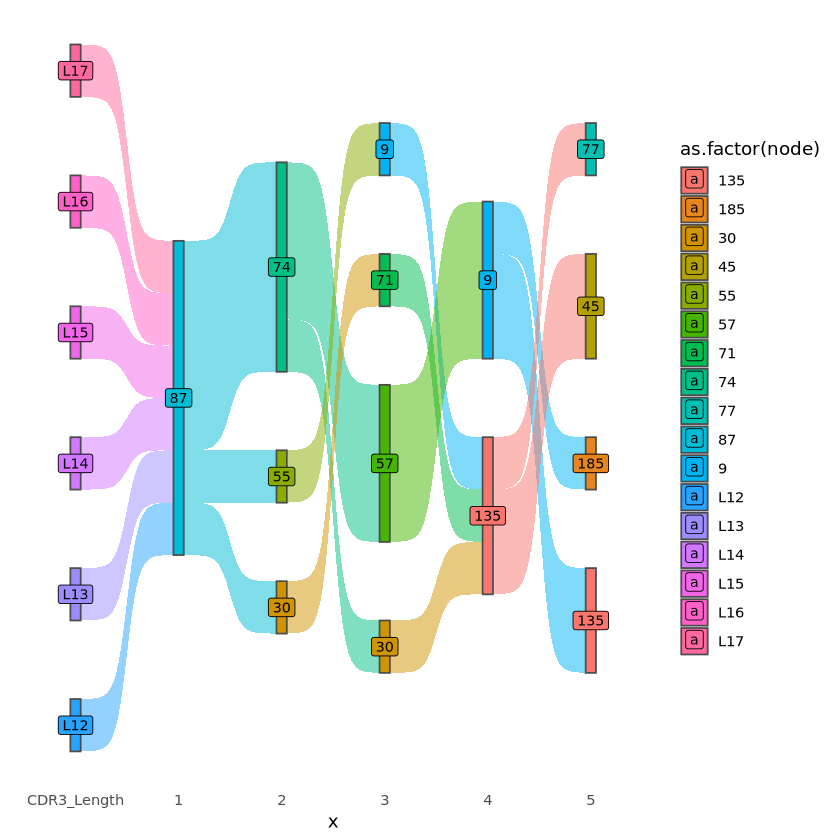

In [ ]:
library(ggplot2)
library(ggsankey)
sig_hits_dt <- as.data.table(significant_hits_with_length)
sig_hits_dt[, Conditional_round := seq(1, nrow(sig_hits_dt))]
sig_hits_dt_long <- data.table::melt(sig_hits_dt, id.vars = 'Conditional_round', variable.name = "CDR3_Length", value.name = 'Site_hla') 
test <- dcast(sig_hits_dt_long, CDR3_Length ~ Conditional_round, value.var = 'Site_hla')
test_sank <- test %>%
  make_long(1,2,3,4,5,6)
pl <- ggplot(test_sank, aes(x = x, next_x = next_x, node = node, next_node = next_node, fill = as.factor(node))) +
  geom_sankey(flow.alpha = 0.5, node.color = "gray30") +
  scale_fill_discrete(drop=FALSE) + 
  geom_sankey_label(aes(label = node), size = 3, color = "black") +
  theme_sankey()
ggsave('/work_beegfs/sukmb667/projects/cdr3-qtl/healthy_and_ibd/plots/CDR3_QTLs_sankey_plot.png', 
    pl, width = 10, height = 7)

In [2]:
hla_alleles_long <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/reference_data/hla_msa/DRB1_long.tsv')

In [85]:
hla_alleles_patients <- fread('/work_beegfs/sukmb667/projects/cdr3-qtl/Emerson_DeWitt/hla_patients_site_variation.tsv')
alleles_in_dataset <- unique(hla_alleles_patients$allele)

In [84]:
site_matrix <- function(sites){
    ref_sites <- data.table::dcast(hla_alleles_long[site %in% sites], allele ~ site, value.var = 'AA')[allele %in% unique(hla_alleles_patients$allele)]
    combin <- apply(ref_sites[,-1], 1, function(x) paste0(sites,x, collapse = '_'))
    ref_sites$comb <- combin
    ref_sites <- ref_sites[, .(allele, comb)]
    return(ref_sites)
}


In [112]:
sites <- c(13,71, 87)
test <- site_matrix(sites)
head(test)


allele,13,71,87
<chr>,<chr>,<chr>,<chr>
DRB1*01:01,F,R,E
DRB1*01:02,F,R,E
DRB1*01:03,F,E,E
DRB1*03:01,S,K,E
DRB1*04:01,H,K,E
DRB1*04:02,H,E,E


allele,comb
<chr>,<chr>
DRB1*01:01,13F_71R_87E
DRB1*01:02,13F_71R_87E
DRB1*01:03,13F_71E_87E
DRB1*03:01,13S_71K_87E
DRB1*04:01,13H_71K_87E
DRB1*04:02,13H_71E_87E


In [110]:
drb1_test <- unique(hla_alleles_patients[gene == 'DRB1'][
    , site := gsub('P', '', site)][,
    .(allele, patient_id_Emerson, homo_hetero)])
head(drb1_test)

allele,patient_id_Emerson,homo_hetero
<chr>,<int>,<int>
DRB1*08:01,17,1
DRB1*08:01,34,1
DRB1*08:01,56,1
DRB1*08:01,151,1
DRB1*08:01,170,1
DRB1*08:01,237,1


In [115]:
drb1_patient_comb <- merge(drb1_test, test, by = 'allele')
head(drb1_patient_comb)

allele,patient_id_Emerson,homo_hetero,comb
<chr>,<int>,<int>,<chr>
DRB1*01:01,7,1,13F_71R_87E
DRB1*01:01,11,1,13F_71R_87E
DRB1*01:01,24,1,13F_71R_87E
DRB1*01:01,30,1,13F_71R_87E
DRB1*01:01,32,1,13F_71R_87E
DRB1*01:01,33,1,13F_71R_87E


In [116]:
data.table::dcast(drb1_patient_comb, patient_id_Emerson ~ comb, value.var = 'homo_hetero', fun.aggregate = sum)

patient_id_Emerson,13F_71E_87E,13F_71R_87E,13G_71R_87E,13H_71E_87E,13H_71K_87E,13H_71R_87E,13R_71A_87E,13R_71R_87E,13S_71E_87E,13S_71K_87E,13S_71R_87E,13Y_71R_87E
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0,2,0,0,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,1,0
5,1,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0,1
7,0,1,0,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,1,0,0,0,1,0
9,0,0,0,0,0,0,0,0,1,0,0,1


In [82]:
head(drb1_ref_sites)
head(hla_alleles_patients)

allele,1,2,3,4,5,6,7,8,9,⋯,228,229,230,231,232,233,234,235,236,237
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
DRB1*01:01,G,D,T,R,P,R,F,L,W,⋯,S,G,L,Q,P,T,G,F,L,S
DRB1*01:02,G,D,T,R,P,R,F,L,W,⋯,S,G,L,Q,P,T,G,F,L,S
DRB1*01:03,G,D,T,R,P,R,F,L,W,⋯,S,G,L,Q,P,T,G,F,L,S
DRB1*03:01,G,D,T,R,P,R,F,L,E,⋯,S,G,L,Q,P,R,G,F,L,S
DRB1*04:01,G,D,T,R,P,R,F,L,E,⋯,S,G,L,Q,P,T,G,F,L,S
DRB1*04:02,G,D,T,R,P,R,F,L,E,⋯,S,G,L,Q,P,T,G,F,L,S


site,gene,allele,aa,ref_aa,change,n_variat,variat,homo_hetero,patient_id_Emerson
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>
P114,A,A*29:01,R,R,0,4,"R,H,Q,E",1,5
P114,A,A*29:01,R,R,0,4,"R,H,Q,E",1,114
P114,A,A*29:01,R,R,0,4,"R,H,Q,E",1,362
P114,A,A*29:01,R,R,0,4,"R,H,Q,E",1,390
P114,A,A*29:01,R,R,0,4,"R,H,Q,E",1,491
P114,A,A*03:02,R,R,0,4,"R,H,Q,E",1,186


In [69]:
drb1 <- hla_alleles_patients[gene == 'DRB1'][
    , site := gsub('P', '', site)][,
    .(allele, patient_id_Emerson, site, aa, homo_hetero)]
drb1[, site_aa := paste0(site, '_', aa)]

In [71]:
drb1_prep <- drb1[, .(allele, patient_id_Emerson, site_aa, homo_hetero)]
head(drb1_prep[patient_id_Emerson == 17], 10)

allele,patient_id_Emerson,site_aa,homo_hetero
<chr>,<int>,<chr>,<int>
DRB1*08:01,17,10_Y,1
DRB1*13:02,17,10_Y,1
DRB1*08:01,17,11_S,1
DRB1*13:02,17,11_S,1
DRB1*08:01,17,13_G,1
DRB1*13:02,17,13_S,1
DRB1*08:01,17,26_F,1
DRB1*13:02,17,26_F,1
DRB1*08:01,17,28_D,1


In [74]:
drb1_prep_wide <- data.table::dcast(drb1_prep, allele + patient_id_Emerson ~ site_aa, value.var = 'homo_hetero',fill = 0)

In [76]:
drb1_prep_wide[patient_id_Emerson == 17]

allele,patient_id_Emerson,10_E,10_Q,10_Y,11_D,11_G,11_L,11_P,11_S,⋯,74_L,74_Q,74_R,96_E,96_H,96_Q,96_Y,9_E,9_K,9_W
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
DRB1*08:01,17,0,0,1,0,0,0,0,1,⋯,1,0,0,0,1,0,0,1,0,0
DRB1*13:02,17,0,0,1,0,0,0,0,1,⋯,0,0,0,0,1,0,0,1,0,0


In [83]:
head(drb1_ref_sites)

allele,1,2,3,4,5,6,7,8,9,⋯,228,229,230,231,232,233,234,235,236,237
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
DRB1*01:01,G,D,T,R,P,R,F,L,W,⋯,S,G,L,Q,P,T,G,F,L,S
DRB1*01:02,G,D,T,R,P,R,F,L,W,⋯,S,G,L,Q,P,T,G,F,L,S
DRB1*01:03,G,D,T,R,P,R,F,L,W,⋯,S,G,L,Q,P,T,G,F,L,S
DRB1*03:01,G,D,T,R,P,R,F,L,E,⋯,S,G,L,Q,P,R,G,F,L,S
DRB1*04:01,G,D,T,R,P,R,F,L,E,⋯,S,G,L,Q,P,T,G,F,L,S
DRB1*04:02,G,D,T,R,P,R,F,L,E,⋯,S,G,L,Q,P,T,G,F,L,S


In [ ]:
hla_matrices <- paste0('../hla_matrices_v3/with_pcs/',list.files('../hla_matrices_v3/with_pcs/'))
pcs <- 3

for (path_in in dir_content{
    dir_analysis <- paste0(path_in, '/conditional_analysis/')
    if (!file.exists(dir_analysis)) {
        dir.create(dir_analysis, recursive = TRUE)
        }
    pairs_to_test <- paste0(path_in,'/cdr3_hla_pairs/')
    sample_size <- unlist(strsplit(path_in, '/'))[3]
    manova_cond_all <- fread(paste0(path_in,'/',sample_size,'_manova.tsv'))
    bonf <- 0.01 / nrow(na.omit(manova_cond_all))
            
    source('Conditional_haplotype_HLA_tutorial.R')
                 }

In [ ]:
fread('../cdr3_hla_pairs/irt_freq_unique/')

In [2]:
manova_cond_all <- fread('../manova_results_9PCs.tsv')
head(manova_cond_all)

Res.Df,Df,Gen.var.,Pillai,approx.F,num.Df,den.Df,Pr..F.,pair,Omnibus,model,P_val,variance_explained
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
68,NA,0.6021247,NA,NA,NA,NA,NA,A:105:12:P106,0.10842643,null,0.6645130,0.008500812
69,1,0.5997493,0.18312791,0.5899523,19,50,8.959403e-01,A:105:12:P106,0.11692724,full,0.7576517,0.008500812
1887,NA,0.7998342,NA,NA,NA,NA,NA,A:105:12:P107,0.03137624,null,0.0000000,0.001535383
1888,1,0.8006578,0.03070092,2.9582877,20,1868,1.200481e-05,A:105:12:P107,0.03291163,full,0.0000000,0.001535383
1887,NA,0.7540988,NA,NA,NA,NA,NA,A:105:12:P108,0.03913627,null,0.0000000,0.001494502
1888,1,0.7546979,0.02484191,2.5059115,19,1869,3.311790e-04,A:105:12:P108,0.04063077,full,0.0000000,0.001494502


In [ ]:
hla_matrices <- paste0('../hla_matrices_v3/with_pcs/',list.files('../hla_matrices_v3/with_pcs/'))
dir_analysis <- '/conditional_analysis/haplotype_approach/'
if (!file.exists(dir_analysis)) {
    dir.create(dir_analysis, recursive = TRUE)
    }
pairs_to_test <- '../cdr3_hla_pairs_9PCs/'
manova_cond_all <- fread('../manova_results_9PCs.tsv')
bonf <- 

In [ ]:
main_manova <- na.omit(fread('../HEALTHY/manova_results.tsv')) %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE) %>% 
    arrange(., Pr..F., desc(variance_explained))
bonf <- 0.01 / nrow(main_manova)
hla_genes <- c('DRB1','A', 'B', 'C', 'DPA1', 'DPB1', 'DQA1','DQB1')

cond_manova_template <- read_tsv('../conditional_analysis//v2//manova_template.tsv')[0,] %>% 
    separate(pair, into = c('HLA', 'Site_hla', 'Length_cdr3', 'Position_cdr3'), sep = ':', remove = FALSE)



In [19]:
-log10(.Machine$double.xmin)

[1] 307.6527

In [ ]:
manova_results <- manova_cond_all %>% 
        filter(model == 'full') %>%
        arrange(., `Pr(>F)`,desc(variance_explained))
     
hit <- manova_results$pair[1]
g_s_l_p <- unlist(strsplit(hit, '_'))
condition_site <- paste(g_s_l_p[1:2], collapse= '_')
condition_site_df <- fread(paste0(hla_matrices, grep(paste0(condition_site, '_'), list.files(hla_matrices), value = TRUE))) %>%
    dplyr::select(-G_S) %>% dplyr::select(!contains('PC'))
colnames(condition_site_df) <- gsub('allele', condition_site, colnames(condition_site_df))
if(first){
    covariates_df <- condition_site_df
    first <- FALSE
    } else {
    covariates_df <- inner_join(covariates_df, condition_site_df)
    }

sites <- colnames(covariates_df)[-1] 

hit_pattern <- paste0(condition_site,'_')
#################
pairs_to_test <- grep(hit_pattern, pairs_to_test, value = TRUE, invert = TRUE)

dir_results <- paste0(dir_analysis, condition_site,'/')
    
if (!file.exists(dir_results)) {
dir.create(dir_results, recursive = TRUE)
}

first <- TRUE
for (f in pairs_to_test){
    
    cdr3_hla_matrix <- na.omit(fread(f)) %>% left_join(covariates_df, by = 'patient_id')
    pair_name <- cdr3_hla_matrix$pair[1]
    
    manova_df <- mlm_fun_conditional_PCs(cdr3_hla_matrix, dir_results, sites, n_pcs = pcs) 
    if (first){
        manova_cond_all <- manova_df[0,]
        first <- FALSE
    }
    
    if (is.null(manova_df)){
        next
    } else {

        manova_cond_all <- rbind(manova_cond_all, manova_df, fill=TRUE)
        
    }
    }